# MC Dropout
https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py

In [90]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

keras = tf.keras
tfd = tfp.distributions

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

Tensorflow Version: 2.0.0-beta0
Tensorflow Probability Version: 0.8.0-dev20190610


In [91]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [92]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [93]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

In [103]:
# MC Dropout parameters

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the nummer of neurons
n_hidden = [128, 128]

# batch size for training
batch_size = 128

# training epochs 
epochs = 6

# prior lenght scale
lengthscale = 1e-2

# dropout rate for all dropout layers in the network, 1. means drop all
dropout = 0.5

# model precision used for regularization
tau = 1.0

# regularization
reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

# MCMC Samples
T = 50

# GloVe Word Embedding

In [95]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [96]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# Model

In [97]:
inputs = keras.Input(shape=(x_train_padded.shape[1],), dtype='int32')

# embedding layer
embedding_layer = keras.layers.Embedding(len(word_index.index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
inter = embedding_layer(inputs)

for i in range(len(n_hidden)):
    inter = keras.layers.Dropout(dropout)(inter, training=True)
    inter = keras.layers.Dense(n_hidden[i], activation='relu', kernel_regularizer=keras.regularizers.l2(reg))(inter)

inter = keras.layers.Dropout(dropout)(inter, training=True)
inter = keras.layers.Flatten()(inter)
outputs = keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(reg), activation="sigmoid")(inter)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2697)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2697, 50)          4429400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2697, 50)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 2697, 128)         6528      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2697, 128)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 2697, 128)         16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2697, 128)         0   

In [98]:
tb_callback = keras.callbacks.TensorBoard(log_dir='logs') 

model.fit(x_train_padded, y_train, validation_split=0.05, epochs=epochs, batch_size=batch_size, callbacks=[tb_callback])
loss, accuracy = model.evaluate(x_train_padded, y_train)

Train on 23750 samples, validate on 1250 samples
Epoch 1/6
23750/23750 [==============================] - 27s 1ms/sample - loss: 0.7167 - acc: 0.5690 - val_loss: 0.6111 - val_acc: 0.6640
Epoch 2/6
23750/23750 [==============================] - 26s 1ms/sample - loss: 0.5752 - acc: 0.7054 - val_loss: 0.5907 - val_acc: 0.6872
Epoch 3/6
23750/23750 [==============================] - 26s 1ms/sample - loss: 0.5435 - acc: 0.7327 - val_loss: 0.5687 - val_acc: 0.7160
Epoch 4/6
23750/23750 [==============================] - 26s 1ms/sample - loss: 0.5235 - acc: 0.7456 - val_loss: 0.5285 - val_acc: 0.7440
Epoch 5/6
23750/23750 [==============================] - 25s 1ms/sample - loss: 0.5172 - acc: 0.7524 - val_loss: 0.5055 - val_acc: 0.7600
Epoch 6/6
25000/25000 [==============================] - 42s 2ms/sample - loss: 0.4843 - acc: 0.7735


1/1 [==============================] - 0s 15ms/sample


(array([30., 31., 35., 11.,  9., 14., 51., 35., 24., 10.]),
 array([0.00490576, 0.09534185, 0.18577794, 0.27621403, 0.36665012,
        0.45708621, 0.54752229, 0.63795838, 0.72839447, 0.81883056,
        0.90926665]),
 <a list of 10 Patch objects>)

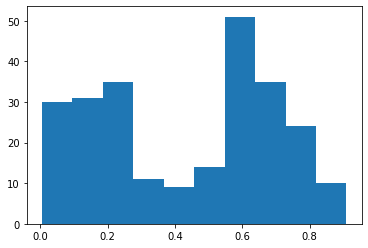

In [102]:
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)

def predict(X_test, y_test):
    """
        Function for making predictions with the Bayesian neural network.
        @param X_test   The matrix of features for the test data


        @return m       The predictive mean for the test target variables.
        @return v       The predictive variance for the test target
                        variables.
        @return v_noise The estimated variance for the additive noise.
    """
        
    X_test = np.array(X_test, ndmin = 2)
    y_test = np.array(y_test, ndmin = 2).T

    # We compute the predictive mean and variance for the target variables
    # of the test data

    standard_pred = model.predict(X_test, batch_size=500, verbose=1)
    standard_pred = standard_pred * std_y_train + mean_y_train
    rmse_standard_pred = np.mean((y_test.squeeze() - standard_pred.squeeze())**2.)**0.5

    Yt_hat = np.array([model.predict(X_test, batch_size=500, verbose=0) for _ in range(T)])
    Yt_hat = Yt_hat * std_y_train + mean_y_train
    MC_pred = np.mean(Yt_hat, 0)
    rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5
    
    # We compute the test log-likelihood
    log_likelihood = (tf.reduce_logsumexp(-0.5 * tau * (y_test[None] - Yt_hat)**2., 0) - np.log(T) 
        - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(log_likelihood)

    return rmse_standard_pred, rmse, test_ll

rmses = []
for i in range(250):
    rmse_standard_pred, rmse, test_ll = predict(x_test_padded[i:i+1], y_test[i:i+1])
    rmses += [rmse]

plt.hist(rmses)